# Explanations 

First, in our diffusion model, we define a markovian noising process, where we gradually add noise. Then, we try to predict the noise backwards (with a neural net. that understands images).

We only predict the mean, and fix the variance based on the variance we defined in the forward-noising process (not learning a covariance).

***DDPM vs. DDIM***

DDIM allows us to formulate diffusion in a non-markovian way, so we can deterministacally sample and add noise. It is basically sampling one noise-vector, and using this to 'jump' to an arbitrary sample, instead of taking steps.

***? what is an intuitive explanation for how DDIMs vs DDPMS work, how can we formulate them, understand, and sample from them???***

Here is a visualization:

In [1]:
import torch
from PIL import Image
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03945452..1.0169384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1395194..1.0827188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20494609..1.1266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26397932..1.1659588].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32139477..1.2037425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38216457..1.2410195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4432

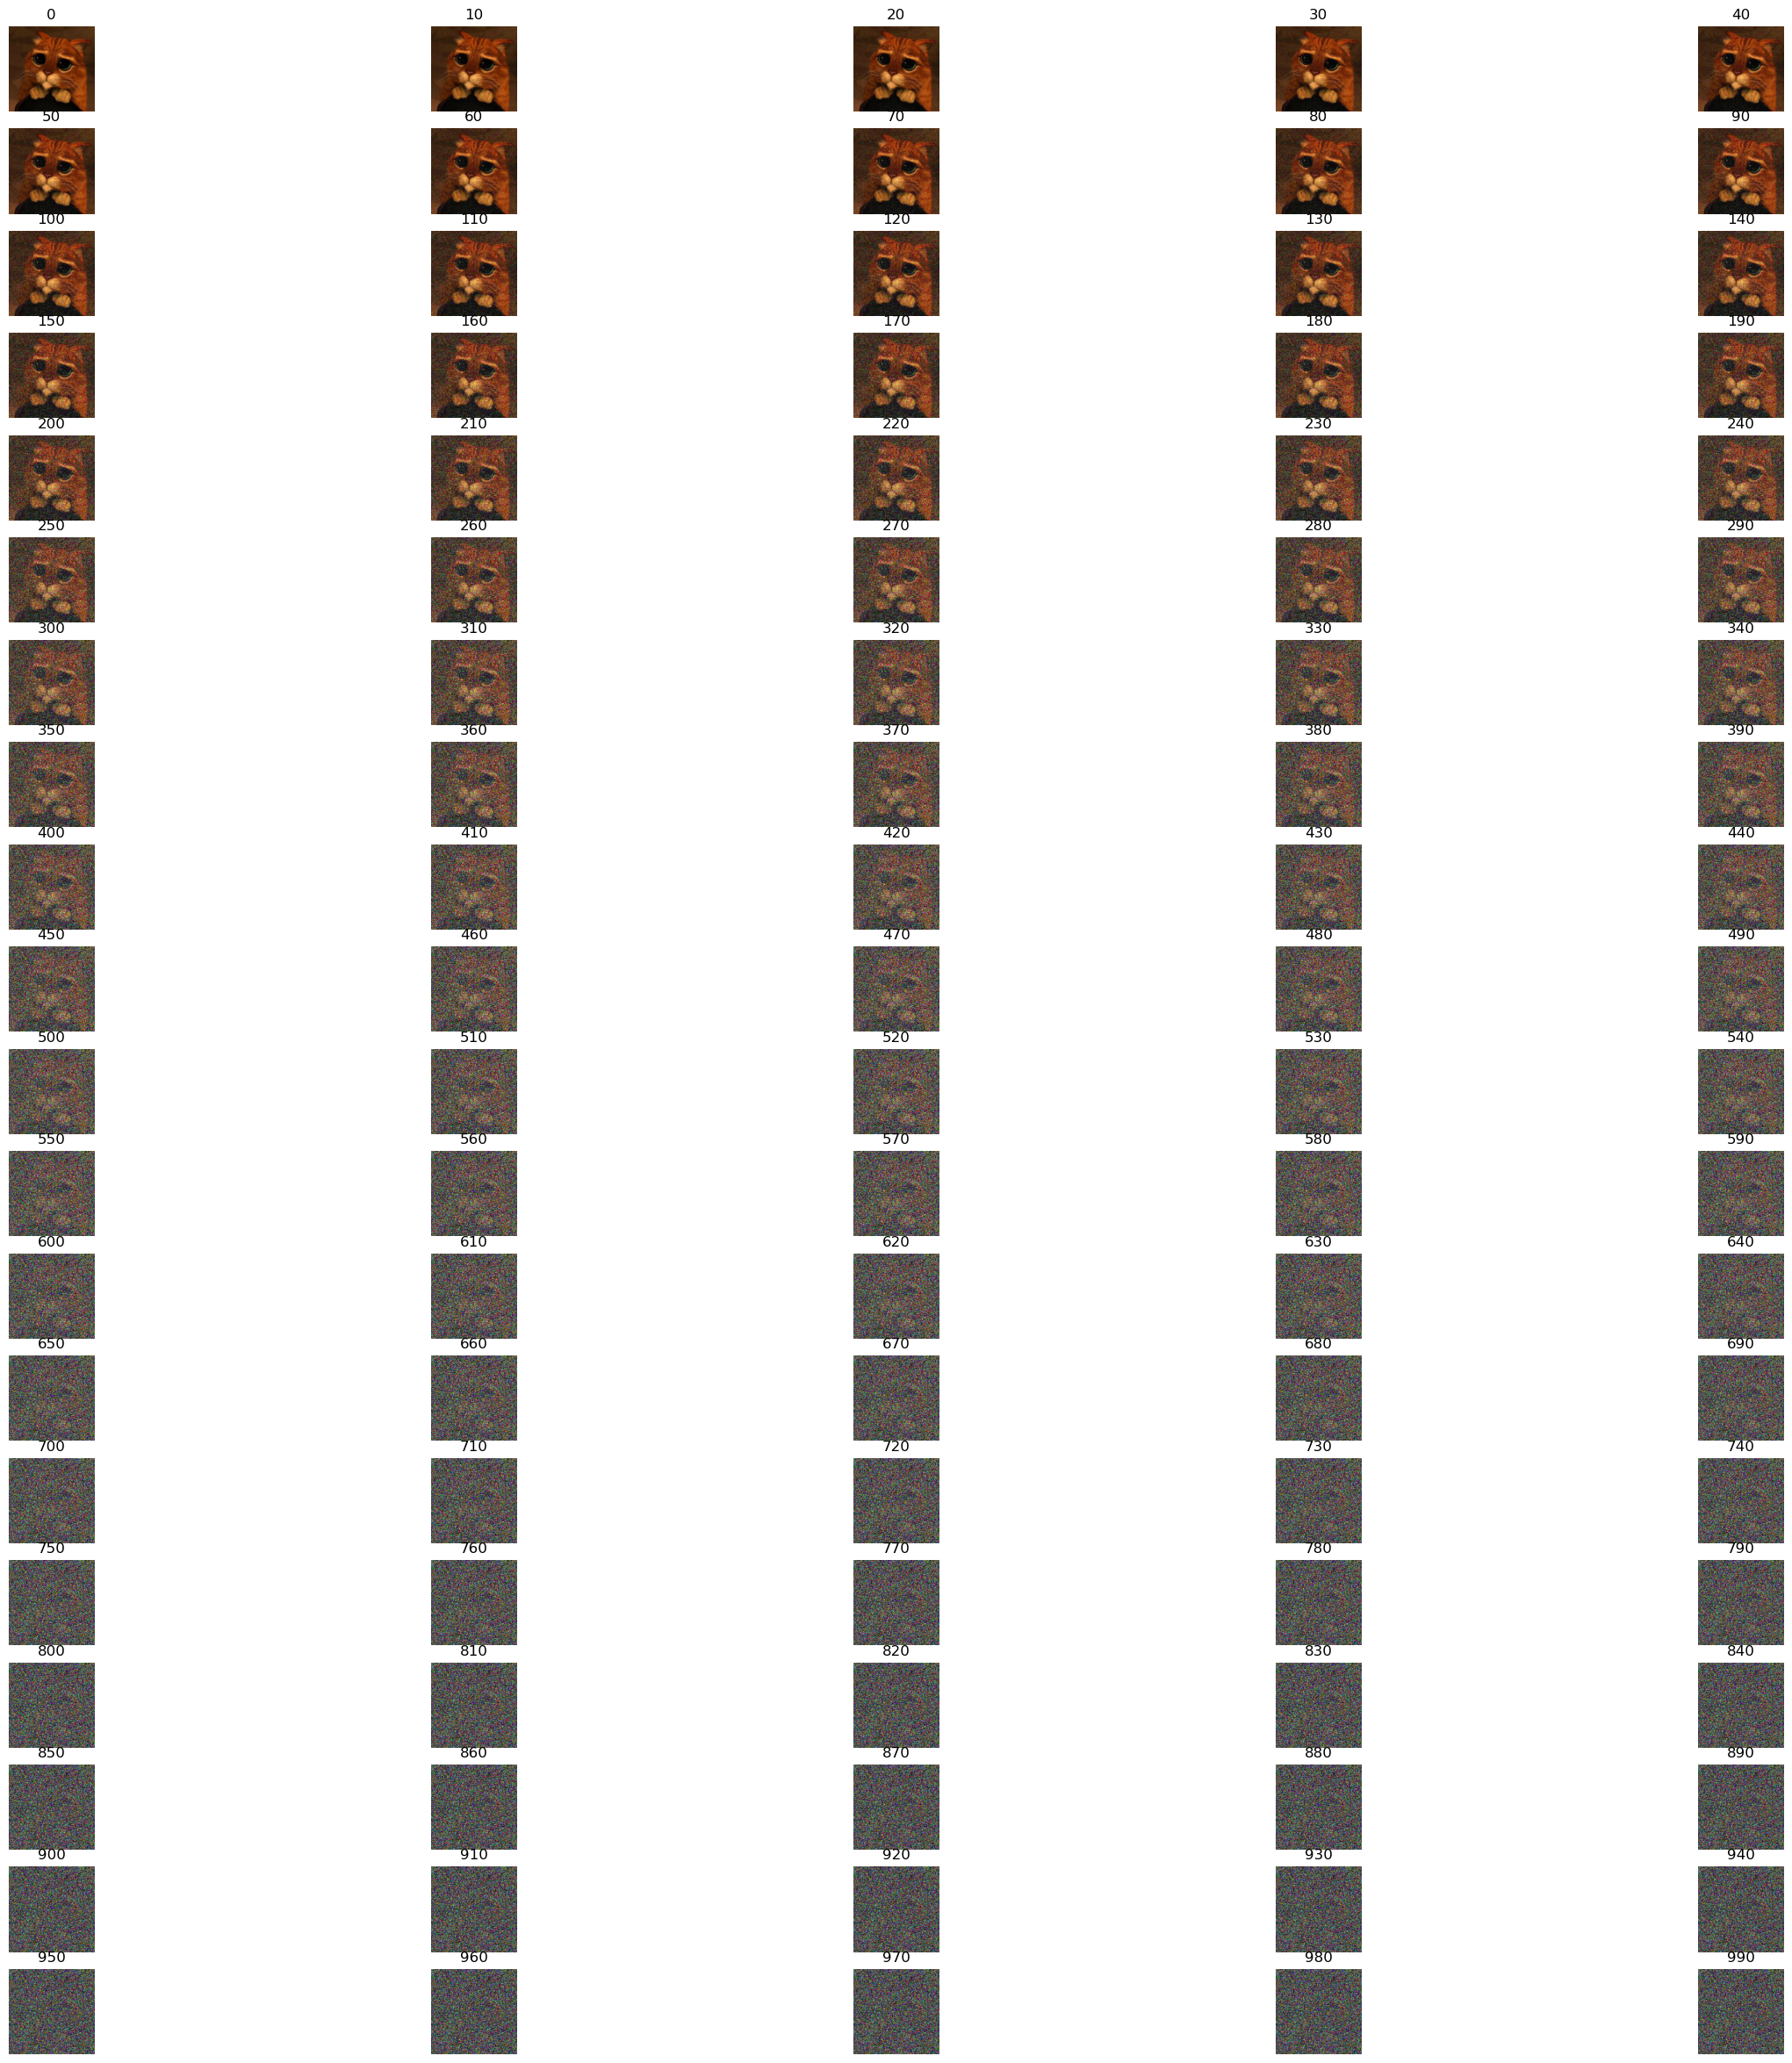

In [10]:
# We will be training our neural net. to predict the 
# noise that created an image (which is the same) as
# predicting the lower noising-step




image = Image.open('img.jpg')
to_tensor = torchvision.transforms.ToTensor()
image = to_tensor(image)


# showing all steps, or just current step
def add_noise(image,steps=100,current_step=None):
    
    # alphas, betas, alpha_cumprod.
    # makes the noising exponentially faster
    # but on same-scale
    betas = torch.linspace(0.0001**0.5,0.02**0.5,steps)**2
    alphas = 1-betas
    alphas_cumprod = torch.cumprod(alphas,dim=0)
    
    # normal distr.
    # DDIM sampling
    noise = torch.randn_like(image)
    
    if current_step is None:
        # having 10x less than steps!
        num_rows = steps // 50 + steps % 50
        fig,subplots = plt.subplots(num_rows,5)
        fig.set_size_inches(30,30)
        for i in range(steps // 10):
            
            alpha = alphas_cumprod[i*10]
            beta = 1-alpha
            noised_image = noise*beta**0.5 + image*alpha**0.5 
            subplots[i // 5][i % 5].imshow(noised_image.permute(1,2,0))
            subplots[i // 5][i % 5].set_title(f"{i*10}")
            subplots[i // 5][i % 5].axis("off")
        
    else:
        alpha = alphas_cumprod[current_step]
        beta = 1-alpha
        
        noised_image = noise*beta**0.5 + image*alpha**0.5 
        
        plt.imshow(noised_image.permute(1,2,0))
        


add_noise(image,1000,None)

    

## Learning Objective

In DDPM's, we want to predict the noise that makes up an image, at any arbitrary step. 

We acheive this loss objective, because we are actually trying to predict the mean of the previous noise-step (x_t-1), and this is made up of the ground-truth noise.

So when we plug this into a formula, we can get the mean, and then add back in the variance. And we could then continously sample; but all we care about for now is the training objective:
- Define a random timestep
- Define a noise-vector, add this to the image
- Do MSE loss, noise-vector is the target, and the models output given the noisy image, and the timestep is the prediction

> Note that the actual loss-formula tells us to weight more important/large noising steps more powerfully, however we ignore this, as at each step we want the model to be robust at predicting the noise, and the step itself shouldn't matter.

The reason we may want to do this, is because at earlier/more-noised steps, we want the model to be able to generate a variety, a of images, and then later on it will hone in on the image that was chosen in an earlier-step.

In [11]:
# very stupid model
model = lambda x: x

'''Adding random noise
to a batch corresponding to 
random-timesteps.'''

class DDPM:
    def __init__(self,steps,betas):
        self.betas = torch.linspace(betas[0]**0.5,betas[1]**0.5,steps) ** 2
        self.alphas = 1-self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,dim=0)
        self.steps= steps
        
    def add_random_noise(self,batch):
        # for each batch, add-noise,
        # and return noisy image + noise
        input_shape = batch.shape
        # easy to deal with
        batch = batch.view(input_shape[0],-1)
        noise = torch.randn_like(batch)
        # broadcast across dim=1
        steps = torch.randint(0,self.steps,size=(batch.shape[0],))
        
        # selecting from alpha bars
        # B, 1
        alpha_bars = self.alphas_cumprod[steps].view(-1,1)
        
        # adding according to noising process
        # std dev and mean
        noised_images = alpha_bars**0.5 * batch + (1-alpha_bars)**0.5 * noise
        noised_images = noised_images.view(input_shape)
        
        # step doesn't matter; predicting
        # same ground-truth noise!
        noise = noise.view(input_shape)
        return noised_images, noise
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39392883..1.2077402].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7294406..2.230725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.260957..2.7251055].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4498485..2.12912].


torch.Size([4, 3, 280, 280])
torch.Size([4, 3, 280, 280])


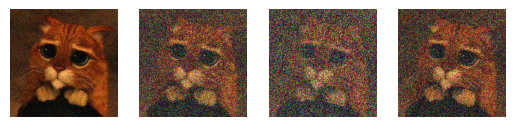

In [33]:
# testing out noiser
# with two noisings

images = torch.stack([image,image,image,image],dim=0)
ddpm = DDPM(1000,[0.0001,0.02])

out = ddpm.add_random_noise(images)
print(out[0].shape)

fig,axes = plt.subplots(1,4)
axes[0].imshow(out[0][0].permute(1,2,0))
axes[1].imshow(out[0][1].permute(1,2,0))
axes[2].imshow(out[0][2].permute(1,2,0))
axes[3].imshow(out[0][3].permute(1,2,0))

for ax in axes:
    ax.axis('off')
    
print(out[1].shape)

In [5]:
# now, we would just calculate MSE loss 
# between the model and the actual noise!

> So, why DDPM in the first place? Well, since we need to sample from nothing (noise), but we also want to train the model to build-up our image, diffusion is great, because it allows us to understand our image at each step, and allows the model during inference to start by kind of predicting randomly, but gain a 'feel' for what the image is; alowing us to effectively 'sample' from the true distribution of images effectively.

The key is the models training to predict noise at *each* step

# DDIM inference:

DDIM allows us to deterministically sample an arbitrary step in the model when we predict the noise at a step. Basically, we define a non-markovian noising process, and this allows for the following ability for inference:
- we are

# Guidance
We can train the model to take some text tokens (Ideally from a pre-trained model), or some other embedding (like a class embedding) for the model to learn to generate images conditionally. This is mathematically just a conditional distribution, and the model will learn it like it would learn to approximate another distribution (in the DiT we make the class embeddings play a role in AdaLN params).

### CFG
Classifier-free guidance is a way to beef-up the capability of our model; we can, through each de-noising step during inference do the following:
- Apply formula: